In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

In [4]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)

data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [6]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


In [7]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 2e-5

In [8]:
# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = [2,2,2,2]

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, i) for i in self.num_labels])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        
        logits = [torch.sigmoid(logit) for logit in logits]
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:, i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss

            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

# Define compute metrics for evaluation
def compute_metrics_multi(p):
    logits = p.predictions # logits list<tensor(bs, num_label)> ~ list of batch prediction per class 
    label_batch = p.label_ids

    # print(p.predictions)
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = [torch.topk(torch.tensor(logit, dtype=torch.float), 1)[1] for logit in logits] # list<tensor(bs)>
    batch_size = label_batch.shape[0]
    num_label = len(hyp)
    for i in range(batch_size):
        hyps = []
        labels = torch.tensor(label_batch[i,:], dtype=torch.float)
        for j in range(num_label):
            hyps.append(hyp[j][i].item())

        hyps = torch.tensor(hyps, dtype=torch.float)
        list_hyp.append(hyps)
        list_label.append(labels)
    
    accuracy = accuracy_score(list_label, list_hyp)
    # print(accuracy)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(list_label, list_hyp, average='micro', zero_division=0)
    f1_macro = f1_score(list_label, list_hyp, average='macro', zero_division=0)

    # print(classification_report(list_label, list_hyp, zero_division=0, target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [10]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [11]:
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)

def get_dataloaders(sequence_length, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=num_workers, worker_init_fn=seed_worker,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=num_workers, worker_init_fn=seed_worker,
    )

    return train_loader, val_loader

In [12]:
manager = Manager()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

In [13]:
def train_model(sequence_length, model_name, metrics, seed=42, layers_freezed=6, num_workers=4):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < layers_freezed:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    train_loader, val_loader = get_dataloaders(sequence_length, num_workers)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()
        
        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            best_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'model-{sequence_length}-{layers_freezed}-{seed}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time

    if accelerator.is_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])
        
    accelerator.print(f"\nAccuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Duration: {duration}")

In [14]:
# Tokenize each text and calculate their lengths
token_lengths = [len(tokenizer.tokenize(text)) for text in X_train]

# Calculate the average length
average_length = sum(token_lengths) / len(token_lengths)
max_length = max(token_lengths)

print("Average length of tokenized text:", average_length)
print("Max token length:", max_length)

Average length of tokenized text: 54.3126407204889
Max token length: 2591


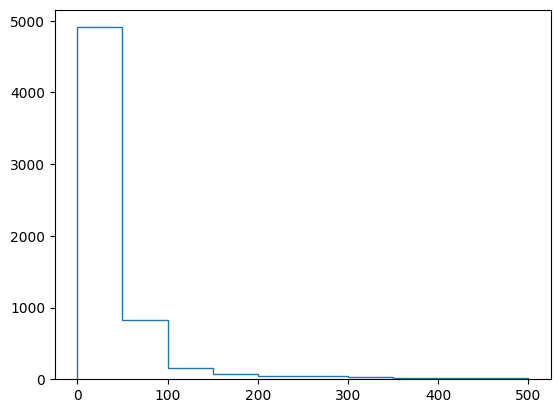

In [15]:
counts, bins = np.histogram(token_lengths, range=(0, 500))
plt.stairs(counts, bins)
plt.show()

# HYPERPARAMETER TUNING

In [16]:
sizes = [16, 32]
lengths = [80, 96, 128]

used_sizes = []
used_lengths = []

for size in sizes:
    BATCH_SIZE = size
    for length in lengths:
        print("=========================================================================================")
        print(f"Batch size: {BATCH_SIZE}, sequence length: {length}")
        used_sizes.append(BATCH_SIZE)
        used_lengths.append(length)
        
        args = (length, 'indobenchmark/indobert-base-p1', (accuracies, f1_micros, f1_macros), 42, 6)
        notebook_launcher(train_model, args, num_processes=2)

Batch size: 16, sequence length: 80
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3252, Accuracy: 0.8952, F1 Micro: 0.7482, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9031, F1 Micro: 0.7662, F1 Macro: 0.7639
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9008, F1 Micro: 0.7611, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1225, Accuracy: 0.9015, F1 Micro: 0.7689, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0882, Accuracy: 0.9007, F1 Micro: 0.7737, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0575, Accuracy: 0.905, F1 Micro: 0.7736, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0461, Accuracy: 0.9026, F1 Micro: 0.7771, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9015, F1 Micro: 0.7673, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9047, F1 Micro: 0.7792, F1 Macro: 0.7726
Epoch 10/10, Train Loss: 0.0204, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3244, Accuracy: 0.8933, F1 Micro: 0.7386, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.9021, F1 Micro: 0.7709, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9056, F1 Micro: 0.7779, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.121, Accuracy: 0.9023, F1 Micro: 0.783, F1 Macro: 0.7795
Epoch 5/10, Train Loss: 0.0845, Accuracy: 0.8999, F1 Micro: 0.7639, F1 Macro: 0.7521
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.9023, F1 Micro: 0.7755, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.04, Accuracy: 0.9029, F1 Micro: 0.7802, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0304, Accuracy: 0.9059, F1 Micro: 0.781, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9042, F1 Micro: 0.7836, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0196, Accuracy: 0.9059, F1 Micro: 0.7821, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3236, Accuracy: 0.894, F1 Micro: 0.736, F1 Macro: 0.7285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.9058, F1 Micro: 0.7794, F1 Macro: 0.7758
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9029, F1 Micro: 0.7727, F1 Macro: 0.7692
Epoch 4/10, Train Loss: 0.1241, Accuracy: 0.9034, F1 Micro: 0.766, F1 Macro: 0.7594
Epoch 5/10, Train Loss: 0.0805, Accuracy: 0.8989, F1 Micro: 0.7752, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.0518, Accuracy: 0.9047, F1 Micro: 0.7709, F1 Macro: 0.7572
Epoch 7/10, Train Loss: 0.0422, Accuracy: 0.9045, F1 Micro: 0.7708, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0338, Accuracy: 0.9019, F1 Micro: 0.7755, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.8997, F1 Micro: 0.7815, F1 Macro: 0.7797
Epoch 10/10, Train Loss: 0.0185, Accuracy: 0.9019, F1 Micro: 0.7675, F1 Macro: 0.7575

Accuracy: 0.8997, F1 Micro: 0.7815, F1 Macro: 0.7797

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8859, F1 Micro: 0.7148, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.898, F1 Micro: 0.743, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9038, F1 Micro: 0.7727, F1 Macro: 0.7674
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9034, F1 Micro: 0.7704, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9023, F1 Micro: 0.7749, F1 Macro: 0.7711
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.8995, F1 Micro: 0.7735, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9048, F1 Micro: 0.775, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9008, F1 Micro: 0.779, F1 Macro: 0.7761
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9019, F1 Micro: 0.7789, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.032, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8867, F1 Micro: 0.721, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9013, F1 Micro: 0.758, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9042, F1 Micro: 0.7689, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9069, F1 Micro: 0.7758, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9028, F1 Micro: 0.7693, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9002, F1 Micro: 0.7803, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9059, F1 Micro: 0.7814, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9055, F1 Micro: 0.7842, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9, F1 Micro: 0.7831, F1 Macro: 0.7822
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8863, F1 Micro: 0.7158, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.9017, F1 Micro: 0.7553, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9038, F1 Micro: 0.7627, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9067, F1 Micro: 0.7738, F1 Macro: 0.7689
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9022, F1 Micro: 0.7596, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.8969, F1 Micro: 0.7767, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9061, F1 Micro: 0.7762, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9033, F1 Micro: 0.7785, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9044, F1 Micro: 0.78, F1 Macro: 0.7764
Epoch 

In [17]:
results = pd.DataFrame({
    'Batch Size': used_sizes,
    'Sequence Length': used_lengths,
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'hyperparameters_tuning.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

for seed in seeds:
    print("=====================")
    print("SEED:", seed)
    set_seed(seed)
    
    LEARNING_RATE = 2e-5
    BATCH_SIZE = 32
    args = (96, 'indobenchmark/indobert-base-p1', (accuracies, f1_micros, f1_macros), seed, 6)
    
    notebook_launcher(train_model, args, num_processes=2)

SEED: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.366, Accuracy: 0.8914, F1 Micro: 0.7374, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2436, Accuracy: 0.8992, F1 Micro: 0.7491, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.903, F1 Micro: 0.7625, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9041, F1 Micro: 0.7678, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9022, F1 Micro: 0.7743, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.8984, F1 Micro: 0.7791, F1 Macro: 0.776
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9031, F1 Micro: 0.7775, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9036, F1 Micro: 0.7754, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9016, F1 Micro: 0.778, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0335, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3574, Accuracy: 0.8914, F1 Micro: 0.736, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.9033, F1 Micro: 0.76, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9053, F1 Micro: 0.772, F1 Macro: 0.7622
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9028, F1 Micro: 0.764, F1 Macro: 0.7592
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9038, F1 Micro: 0.7672, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9027, F1 Micro: 0.7784, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9053, F1 Micro: 0.784, F1 Macro: 0.7829
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9058, F1 Micro: 0.7795, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9016, F1 Micro: 0.7793, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9038, F1 Micro: 0.7734, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3558, Accuracy: 0.8911, F1 Micro: 0.7379, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9017, F1 Micro: 0.7593, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.907, F1 Micro: 0.782, F1 Macro: 0.7753
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9066, F1 Micro: 0.7777, F1 Macro: 0.7728
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9003, F1 Micro: 0.7728, F1 Macro: 0.7715
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.903, F1 Micro: 0.7738, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9064, F1 Micro: 0.7772, F1 Macro: 0.7693
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9066, F1 Micro: 0.777, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9069, F1 Micro: 0.7856, F1 Macro: 0.7836
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.903, F1 Micro: 0.7814, F1 Macro: 0.7783

Accuracy: 0.9069, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.8922, F1 Micro: 0.7412, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2377, Accuracy: 0.9027, F1 Micro: 0.7573, F1 Macro: 0.7479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9044, F1 Micro: 0.7652, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9048, F1 Micro: 0.7772, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9045, F1 Micro: 0.7679, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9016, F1 Micro: 0.7816, F1 Macro: 0.7796
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9013, F1 Micro: 0.7733, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9045, F1 Micro: 0.7769, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9045, F1 Micro: 0.7714, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.8991, F1 Micro: 0.7632, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3548, Accuracy: 0.8878, F1 Micro: 0.7219, F1 Macro: 0.7142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2397, Accuracy: 0.8992, F1 Micro: 0.7491, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9045, F1 Micro: 0.7736, F1 Macro: 0.7644
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9031, F1 Micro: 0.7688, F1 Macro: 0.7667
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9014, F1 Micro: 0.7676, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9023, F1 Micro: 0.7748, F1 Macro: 0.7707
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9033, F1 Micro: 0.7691, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9062, F1 Micro: 0.7813, F1 Macro: 0.7767
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9014, F1 Micro: 0.7802, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9023, F1 Micro: 0.7635, F1 M

# NO ACCELERATE

In [23]:
from torch.cuda.amp import autocast, GradScaler

def train_model_no_accel(sequence_length, model_name, seed=42, multi_classifier=False, layers_freezed=6):
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Wrap the model with DataParallel for multi-GPU training
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = torch.nn.DataParallel(model)

    # Freeze specified layers
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < layers_freezed:
                    param.requires_grad = False
            except ValueError:
                continue

    train_loader, val_loader = get_dataloaders(sequence_length, 4)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scaler = GradScaler()

    best_result = None
    model.train()
    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_loss = 0
        model.train()  # Ensure model is in training mode
        for step, batch in enumerate(train_loader):
            inputs = {key: val.to(device, non_blocking=True) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device, non_blocking=True)

            optimizer.zero_grad()
            with autocast():
                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val.to(device, non_blocking=True) for key, val in batch.items() if key != 'labels'}
                labels = batch['labels'].to(device, non_blocking=True)

                with autocast():
                    outputs = model(**inputs)
                    preds = torch.sigmoid(outputs.logits).round()

                all_preds.append(preds)
                all_labels.append(labels)

        # Convert predictions and labels to tensors
        all_preds = torch.cat(all_preds).cpu().numpy().astype(int)
        all_labels = torch.cat(all_labels).cpu().numpy().astype(int)

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            print("Higher f1 achieved, saving model")
            torch.save(model.state_dict(), f'no-accelerate.pth')
            model.module.config.to_json_file(f'no-accelerate-config.json')
            best_result = result

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {epoch_loss / len(train_loader):.4f}, "
              f"Accuracy: {result['accuracy']:.4f}, F1 Micro: {result['f1_micro']:.4f}, F1 Macro: {result['f1_macro']:.4f}")

    duration = time.time() - start_time
    print(f"Accuracy: {best_result['accuracy']:.4f}, F1 Micro: {best_result['f1_micro']:.4f}, F1 Macro: {best_result['f1_macro']:.4f}")
    print(best_result['report'])
    print(f"Training completed in {duration:.2f} seconds.")

In [24]:
set_seed(42)
LEARNING_RATE = 2e-5
train_model_no_accel(96, 'indobenchmark/indobert-base-p1')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs
Higher f1 achieved, saving model
Epoch 1/10, Train Loss: 0.3057, Accuracy: 0.9011, F1 Micro: 0.7632, F1 Macro: 0.7578
Higher f1 achieved, saving model
Epoch 2/10, Train Loss: 0.2020, Accuracy: 0.9061, F1 Micro: 0.7964, F1 Macro: 0.7940
Epoch 3/10, Train Loss: 0.1376, Accuracy: 0.8939, F1 Micro: 0.7218, F1 Macro: 0.7135
Epoch 4/10, Train Loss: 0.0891, Accuracy: 0.9053, F1 Micro: 0.7723, F1 Macro: 0.7685
Epoch 5/10, Train Loss: 0.0550, Accuracy: 0.9014, F1 Micro: 0.7755, F1 Macro: 0.7718
Epoch 6/10, Train Loss: 0.0340, Accuracy: 0.9016, F1 Micro: 0.7752, F1 Macro: 0.7770
Epoch 7/10, Train Loss: 0.0267, Accuracy: 0.9024, F1 Micro: 0.7741, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0220, Accuracy: 0.9014, F1 Micro: 0.7654, F1 Macro: 0.7600
Epoch 9/10, Train Loss: 0.0183, Accuracy: 0.9080, F1 Micro: 0.7864, F1 Macro: 0.7853
Epoch 10/10, Train Loss: 0.0145, Accuracy: 0.9019, F1 Micro: 0.7821, F1 Macro: 0.7837
Accuracy: 0.9061, F1 Micro: 0.7964, F1 Macro: 0.7940
                 

# P100 GPU

In [13]:
train_model(96, 'indobenchmark/indobert-base-p1', 42, 6)

DistributedType.NO


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3272, Accuracy: 0.895, F1 Micro: 0.7418, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.8957, F1 Micro: 0.7836, F1 Macro: 0.7825
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9048, F1 Micro: 0.7656, F1 Macro: 0.7517
Epoch 4/10, Train Loss: 0.122, Accuracy: 0.9051, F1 Micro: 0.7813, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.085, Accuracy: 0.9018, F1 Micro: 0.7885, F1 Macro: 0.7852
Epoch 6/10, Train Loss: 0.0563, Accuracy: 0.9059, F1 Micro: 0.7803, F1 Macro: 0.7767
Epoch 7/10, Train Loss: 0.0422, Accuracy: 0.9053, F1 Micro: 0.7827, F1 Macro: 0.7785
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.9064, F1 Micro: 0.7797, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0268, Accuracy: 0.9037, F1 Micro: 0.7886, F1 Macro: 0.7866
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.9034, F1 Micro: 0.7783, F1 Macro: 0.7755

Accuracy: 0.9037, F

# T4 GPU

In [ ]:
import os
os._exit(0)

In [13]:
notebook_launcher(train_model, (96, 'indobenchmark/indobert-base-p1', 42, 6), num_processes=2)

Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8867, F1 Micro: 0.721, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9013, F1 Micro: 0.758, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9042, F1 Micro: 0.7689, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9069, F1 Micro: 0.7758, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9028, F1 Micro: 0.7693, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9002, F1 Micro: 0.7803, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9059, F1 Micro: 0.7814, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9055, F1 Micro: 0.7842, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9, F1 Micro: 0.7831, F1 Macro: 0.7822
Epoch 10/10,

# INFERENCE

## MULTI GPU

In [14]:
def run_inference():
    # Initialize the accelerator
    accelerator = Accelerator(mixed_precision="fp16")
    # device = torch.cuda
    device = accelerator.device

    # with accelerator.main_process_first():
    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained("/kaggle/working/model-96-6-42")

    train_loader, val_loader = get_dataloaders(96, 4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    start_time = time.time()
    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []

    accelerator.wait_for_everyone()
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device, non_blocking=True) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device, non_blocking=True)

            outputs = model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            all_preds.append(accelerator.gather(preds))
            all_labels.append(accelerator.gather(labels))

    # Convert predictions and labels to tensors
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    accelerator.wait_for_everyone()

    result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

    end_time = time.time()
    duration = end_time - start_time

    # Print results
    accelerator.print(f"\nAccuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    accelerator.print(result['report'])
    accelerator.print(f"Duration: {duration} s")

In [15]:
notebook_launcher(run_inference, num_processes=2)

Launching training on 2 GPUs.

Accuracy: 0.9055, F1 Micro: 0.7842, F1 Macro: 0.7802
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       370
                sara       0.66      0.69      0.67       248
         radikalisme       0.72      0.86      0.79       243
pencemaran_nama_baik       0.72      0.76      0.74       504

           micro avg       0.76      0.81      0.78      1365
           macro avg       0.76      0.80      0.78      1365
        weighted avg       0.77      0.81      0.79      1365
         samples avg       0.46      0.46      0.45      1365

Duration: 4.6305317878723145 s


## SINGLE GPU

In [16]:
run_inference()


Accuracy: 0.9037, F1 Micro: 0.7886, F1 Macro: 0.7866
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.93       362
                sara       0.62      0.78      0.69       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.69      0.82      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.84      0.79      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.47      0.48      0.47      1326

Duration: 4.6490256786346436 s
